## 本分对xgboost调优参考网易云课堂教程全栈数据工程师养成攻略的xgboost内容  （https://github.com/Honlan/fullstack-data-engineer/blob/master/data/Parameter_Tuning_XGBoost_with_Example/XGBoost_models.ipynb)

In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import xgboost as xgb
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn import cross_validation, metrics
from matplotlib import pylab as plt
plot = True
goal = 'Sales'
myid = 'Id'

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# 数据导入

In [2]:
def get_data():
    store = pd.read_csv('./store.csv')
    train_org = pd.read_csv('./train.csv',dtype={'StateHoliday':pd.np.string_})
    test_org = pd.read_csv('./test.csv',dtype={'StateHoliday':pd.np.string_})
    train = pd.merge(train_org,store,on='Store',how='left')
    test = pd.merge(test_org,store,on='Store',how='left')
    feature = test.columns.tolist()
    numerics = ['int16','int32','int64','float16','float32','float64']
    feature_numeric = test.select_dtypes(include = numerics).columns.tolist()
    feature_non_numeric = [f for f in feature if f not in feature_numeric]
    return (train,test,feature,feature_non_numeric)

# 数据处理

In [3]:
def process_data(train,test,features,features_no):
    train = train[train['Open']==1]
    
    test = test[test['Open']==1]
    for rossm in [train,test]:
        rossm['year'] = rossm.Date.apply(lambda x: int(x.split('-')[0]))
        rossm['month']= rossm.Date.apply(lambda x: int(x.split('-')[1]))
        rossm['day']  = rossm.Date.apply(lambda x: int(x.split('-')[2]))
        
#         rossm['promojan'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jan' in x else 0)
#         rossm['promofeb'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Feb' in x else 0)
#         rossm['promomar'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Mar' in x else 0)
#         rossm['promoapr'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Apr' in x else 0)
#         rossm['promomay'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'May' in x else 0)
#         rossm['promojun'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jun' in x else 0)
#         rossm['promojul'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jul' in x else 0)
#         rossm['promoaug'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Aug' in x else 0)
#         rossm['promosep'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Sep' in x else 0)
#         rossm['promooct'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Oct' in x else 0)
#         rossm['promonov'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Nov' in x else 0)
#         rossm['promodec'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Dec' in x else 0)
    
    time_format = '%Y-%m-%d'
    datime = pd.to_datetime(rossm.Date,format = time_format)
    rossm['week_year'] = datime.dt.week
    day_dummies = pd.get_dummies(train['DayOfWeek'],prefix='Day')
#     day_dummies.drop(['Day_7'],axis=1,inplace=True)  #删除周日的数据
    train = train.join(day_dummies)

    
    day_dummies_test = pd.get_dummies(test['DayOfWeek'],prefix='Day')
#     day_dummies_test.drop(['Day_7'],axis=1,inplace=True)  #删除周日数据
    test = test.join(day_dummies_test)
    
    noisy_features = [myid,'Date','Store','year','Day','SchoolHoliday','Open ']
    features = [c for c in features if c not in noisy_features]
    features_non_numeric = [c for c in features_no if c not in noisy_features]
#     features.extend(['year','month','day'])
    class DataFrameInputer(TransformerMixin):
        def __init__(self):
                """
                """
        def fit(self,X,y=None):
            self.fill = pd.Series([X[c].value_counts().index[0] 
                                  if X[c].dtype==np.dtype('O') 
                                   else X[c].mean() for c in X],index = X.columns)
            return self
        def transform(self,X,y=None):
            return X.fillna(self.fill)
        
    train = DataFrameInputer().fit_transform(train)
    test  = DataFrameInputer().fit_transform(test)
        
    le = LabelEncoder()
    for col in features:
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
#     scaler = StandardScaler()
#     for col in set(features) - set(features_no) - set([]):
#         try:
#             scaler.fit(list(train[col])+list(test[col]))
#         except:
#             print(col)
#         train[col] = scaler.transform(train[col])
#         test[col] = scaler.transform(test[col])
    return (train,test,features,features_no)    
       
    

In [4]:
#1、去除销量中的极值,由于无法估计极值对结果的影响，所以拟合模型的时候可以进行两次，去除极值和未去除极值
#再试一下标准差标准误差
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
store = pd.read_csv('./store.csv')

#2、对时间的拆分
def data_processing(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfYear'] = df['Date'].apply(lambda x: x.dayofyear)
    df['WeekOfYear'] = df['Date'].apply(lambda x: x.week)
    df['Month'] = df['Date'].apply(lambda x: x.month)
    df['DayOfMonth'] = df['Date'].apply(lambda x: x.day)
    df['Year'] = df['Date'].apply(lambda x: x.year)
    return df

#4、为每个日期添加过去一个季度，过去半年，过去一年，过去两年的这家店的平均日销售量
def store_sales_each_day(sale):
    
    def add_mean(store,sale,current_date,past_time):
        past_date = current_date - timedelta(days=past_time)
        mean_sale = sale[(sale['Date'] < current_date) & (sale['Date'] > past_date) & (sale['Store'] == store)]['Sales'].mean()
        return mean_sale
    
    sale['past_quater_mean_sale'] = sale.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 90), axis=1)
    sale['past_year_mean_sale'] = sale.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 183), axis=1)
    
    return sale

#测试集调整
def store_sales_each_day_for_test(sale,test):
    
    def add_mean(store,sale,current_date,past_time):
        past_date = current_date - timedelta(days=past_time)
        mean_sale = sale[(sale['Date'] < current_date) & (sale['Date'] > past_date) & (sale['Store'] == store)]['Sales'].mean()
        return mean_sale
    
    test['past_quater_mean_sale'] = test.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 90), axis=1)
    test['past_year_mean_sale'] = test.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 183), axis=1)

    return test

#3、为每家店添加销售量客流量相关的均值,执行顺序在对时间进行拆分后
def add_mean_for_store(sales,store_df=store) :
    mean_sales_promo = []
    mean_sales_no_promo = []
    mean_sales = []
    mean_sales_2013 = []
    mean_sales_2014 = []
    mean_sales_2015 = []
    mean_store_sales_1month = []
    mean_store_sales_2months = []
    mean_store_sales_3months = []
    mean_store_sales_6months = []
    
    
    mean_customers_promo = []
    mean_customers_no_promo = []
    mean_customers = []
    mean_customers_2013 = []
    mean_customers_2014 = []
    mean_customers_2015 = []
    mean_customers_1month = [] 
    mean_customers_2months = [] 
    mean_customers_3months = []
    mean_customers_6months = []
    
    
    for store in store_df['Store']:
        sale = sales[sales['Store']==store]
        
        # mean of sales
        mean_sales.append(sale['Sales'].mean())
        mean_sales_promo.append(sale[sale['Promo'] == 1]['Sales'].mean())
        mean_sales_no_promo.append(sale[sale['Promo'] == 0]['Sales'].mean())
        mean_sales_2013.append(sale[sale['Year'] == 2013]['Sales'].mean())
        mean_sales_2014.append(sale[sale['Year'] == 2014]['Sales'].mean())
        mean_sales_2015.append(sale[sale['Year'] == 2015]['Sales'].mean())
        mean_store_sales_1month.append(sale[(sale['Month'] == 7) & (sale['Year'] == 2015)]['Sales'].mean())                   
        mean_store_sales_2months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 6) & (sale['Year'] == 2015)]['Sales'].mean())
        mean_store_sales_3months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 5) & (sale['Year'] == 2015)]['Sales'].mean())        
        mean_store_sales_6months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 2) & (sale['Year'] == 2015)]['Sales'].mean())
        
        # mean of customers
        mean_customers.append(sale['Customers'].mean())
        mean_customers_promo.append(sale[sale['Promo'] == 1]['Customers'].mean())
        mean_customers_no_promo.append(sale[sale['Promo'] == 0]['Customers'].mean())
        mean_customers_2013.append(sale[sale['Year'] == 2013]['Customers'].mean())
        mean_customers_2014.append(sale[sale['Year'] == 2014]['Customers'].mean())
        mean_customers_2015.append(sale[sale['Year'] == 2015]['Customers'].mean())
        mean_customers_1month.append(sale[(sale['Month'] == 7) & (sale['Year'] == 2015)]['Customers'].mean())                   
        mean_customers_2months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 6) & (sale['Year'] == 2015)]['Customers'].mean())
        mean_customers_3months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 5) & (sale['Year'] == 2015)]['Customers'].mean())        
        mean_customers_6months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 2) & (sale['Year'] == 2015)]['Customers'].mean())
        
    store_df['mean_sales'] = mean_sales
    store_df['mean_sales_promo'] = mean_sales_promo
    store_df['mean_sales_no_promo'] = mean_sales_no_promo
    store_df['mean_sales_2013'] = mean_sales_2013
    store_df['mean_sales_2014'] = mean_sales_2014
    store_df['mean_sales_2015'] = mean_sales_2015
    store_df['mean_store_sales_1month'] = mean_store_sales_1month
    store_df['mean_store_sales_2months'] = mean_store_sales_2months
    store_df['mean_store_sales_3months'] = mean_store_sales_3months
    store_df['mean_store_sales_6months'] = mean_store_sales_6months
    
    store_df['mean_customers'] = mean_customers
    store_df['mean_customers_promo'] = mean_customers_promo
    store_df['mean_customers_no_promo'] = mean_customers_no_promo
    store_df['mean_customers_2013'] = mean_customers_2013
    store_df['mean_customers_2014'] = mean_customers_2014
    store_df['mean_customers_2015'] = mean_customers_2015
    store_df['mean_customers_1month'] = mean_customers_1month
    store_df['mean_customers_2months'] = mean_customers_2months
    store_df['mean_customers_3months'] = mean_customers_3months
    store_df['mean_customers_6months'] = mean_customers_6months
    
    return store_df

def drop_stores(data_test, data):
	stores = data_test['Store'].unique()         
	return data[data_test['Store'].isin(stores)]

#合并销售和商店 
def merge_sale(sale_data, store_data):
    train = sale_data.join(store_data, on='Store', rsuffix='_')
    train = train.drop('Store_',axis=1)
    return train

#添加其他特征
def extra_features(data):
    data['CompetitionOpen'] = 12 * (data['Year'] - data['CompetitionOpenSinceYear']) + (data['Month'] - data['CompetitionOpenSinceMonth'])
    data['PromoOpen'] = 12 * (data['Year'] - data['Promo2SinceYear'])+ (data['WeekOfYear'] - data['Promo2SinceWeek']) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    data = data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1) #删除特征
    
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4,'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3}  
    data['StoreType'].replace(mappings, inplace=True)  
    data['Assortment'].replace(mappings, inplace=True)  
    data['StateHoliday'].replace(mappings, inplace=True)
    data['PromoInterval'].replace(mappings, inplace=True)
#     data = data.drop(['Date'],axis= 1)
    return data

#去除极大极小值
# print('Moving outliers')
# train = rm_outliers(train)

#转换年月日
print('Convert Time')
train = data_processing(train)
test = data_processing(test)

#给商店计算平均销售量
store = add_mean_for_store(train)
store = drop_stores(test, store)

print('add additional past_quater_mean_sale and past_year_mean_sale')
#添加额外特征'past_quater_mean_sale'和'past_year_mean_sale'，这段代码运行时间可能会过长
# train = store_sales_each_day(train)
# test = store_sales_each_day_for_test(train,test)

print('Merging')
#合并
train = merge_sale(train, store)
test = merge_sale(test, store)
# train.to_csv('train_withextra.csv',index=False)
# test.to_csv('test_withextra.csv',index=False)

#额外的特征
train = extra_features(train)
test = extra_features(test)

# holidayofyear = sorted(train[train['StateHoliday'].isin([1,2,3,4])]['DayOfYear'].unique())
# def day2holiday(df,holidayofyear):
#     for holiday in holidayofyear:
#         df['DaysToHoliday' + str(holiday)] = holiday - df['DayOfYear']
#     return df

#计算距离节日的日子数
# train = day2holiday(train,holidayofyear)
# test =  day2holiday(test,holidayofyear)

print('Final output')
#生成最终输入
a1 = train.columns
a2 = ['Date','Sales','Customers','DayOfWeek']
a1 = [f for f in a1 if f not in a2]



Convert Time
add additional past_quater_mean_sale and past_year_mean_sale
Merging
Final output


### 评估函数

In [5]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)

    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

# train,test 数据获取

In [6]:
# train,test,features,features_non_numeric = get_data()

# train,test,features,features_non_numeric = process_data(train,test,features,features_non_numeric)
a1 = train.columns
a2 = ['Date','Sales','Customers']
a1 = [f for f in a1 if f not in a2]
# XGB_native(train,test,a1,features_non_numeric)
rossm_train = dict(list(train.groupby('Store')))
rossm_test = dict(list(test.groupby('Store')))

# 查看模型ntree数量和准确率函数

In [22]:
def modelfit(xgb1,train,test,features,useTranCv=True,cv_folds = 6,early_stopping_rounds = 50):
    if useTranCv:
        xgb_param = xgb1.get_xgb_params()
        xgtrain = xgb.DMatrix(train[features].values,label=train[goal])
        xgtest = xgb.DMatrix(train[features].values)
        cvresult = xgb.cv(xgb_param,xgtrain,num_boost_round=xgb1.get_params()['n_estimators'],nfold=cv_folds,
                    early_stopping_rounds = early_stopping_rounds)
        print(cvresult.shape[0])
        xgb1.set_params(n_estimators = cvresult.shape[0])
        
    xgb1.fit(train[features],train[goal])
    train_predict = xgb1.predict(train[features])
#     train_predprob = xgb1.predict_proba(train[features])[:,1]
    
    print('\n Model Report')
    print('error: %.4g' % rmspe(train[goal].values,train_predict))
    
    feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar',title="feature importances")
    plt.ylabel('feature importance score')

In [7]:
xgb1 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,
                        min_child_weight=1,gamma=0,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )

# modelfit(xgb1,rossm_train[8],rossm_test[8],a1)
modelfit(xgb1,train,test,a1)
print(xgb1.base_score)

KeyboardInterrupt: 

In [49]:
# store = rossm_train[8]
store = train.sort_values('Store').loc[:100000]
y = store['Sales'][:100000]
x = store.drop(['Sales','Customers','Date'],axis=1)[:100000]
y = rossm_train[8]['Sales']
x = rossm_train[8].drop(['Sales','Customers','Date'],axis=1)
X_train,X_test,y_train,y_test = cross_validation.train_test_split(x,y,test_size=0.3)
clf_e = xgb.XGBRegressor()
clf_e.fit(X_train,y_train)

print('XGboost rmspe',rmspe(clf_e.predict(X_test),y_test))
print(clf_e.base_score)

clf_e.fit(x,y)
print('XGboost rmspe',rmspe(clf_e.predict(x),y))

XGboost rmspe 0.08220634825410407
0.5
XGboost rmspe 0.07537490322422452


In [51]:
clf_e

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# 对max_depth和min_child_weight调优

In [19]:
param_test1 = {'max_depth':np.arange(8,16),'min_child_weight':np.arange(8,16)}
xgb1 = xgb.XGBRegressor(learning_rate=0.1,scale_pos_weight=1,seed=27
                        )
gsearch1 = GridSearchCV(xgb1,param_grid=param_test1,n_jobs=-1,iid=False,cv=6)
gsearch1.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_depth': array([ 8,  9, 10, 11, 12, 13, 14, 15]), 'min_child_weight': array([ 8,  9, 10, 11, 12, 13, 14, 15])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [20]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.95003, std: 0.01656, params: {'max_depth': 8, 'min_child_weight': 8},
  mean: 0.95044, std: 0.01666, params: {'max_depth': 8, 'min_child_weight': 9},
  mean: 0.95121, std: 0.01600, params: {'max_depth': 8, 'min_child_weight': 10},
  mean: 0.95091, std: 0.01646, params: {'max_depth': 8, 'min_child_weight': 11},
  mean: 0.95034, std: 0.01701, params: {'max_depth': 8, 'min_child_weight': 12},
  mean: 0.95097, std: 0.01595, params: {'max_depth': 8, 'min_child_weight': 13},
  mean: 0.94839, std: 0.01774, params: {'max_depth': 8, 'min_child_weight': 14},
  mean: 0.94996, std: 0.01653, params: {'max_depth': 8, 'min_child_weight': 15},
  mean: 0.94953, std: 0.01710, params: {'max_depth': 9, 'min_child_weight': 8},
  mean: 0.95073, std: 0.01654, params: {'max_depth': 9, 'min_child_weight': 9},
  mean: 0.95097, std: 0.01666, params: {'max_depth': 9, 'min_child_weight': 10},
  mean: 0.94924, std: 0.01744, params: {'max_depth': 9, 'min_child_weight': 11},
  mean: 0.95072, std: 0.01637, p

100

 Model Report
error: 0.416


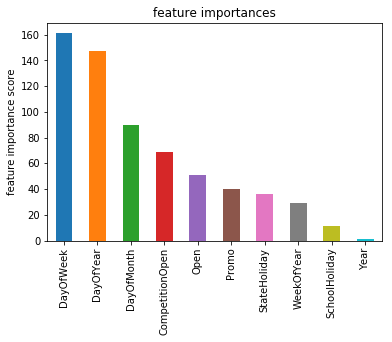

In [23]:
modelfit(xgb1,rossm_train[8],rossm_test[8],a1)

# 对参数gamma、reg_alpha、subsample、colsample_bytree进行调优

In [28]:
param_test3 = {'gamma':[i/10.0 for i in range(0,10)],'subsample':[i/10.0 for i in range(5,11)],'reg_alpha':[i/10.0 for i in range(0,10)],
'colsample_bytree':[i/10.0 for i in range(5,11)]}
xgb3 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,
                        max_depth=10,min_child_weight=13,scale_pos_weight=1,seed=27
                        )
gsearch3 = GridSearchCV(xgb3,param_grid=param_test3,scoring='r2',n_jobs=-1,iid=False,cv=6)
gsearch3.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=13, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [29]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.94276, std: 0.01555, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.0, 'subsample': 0.6},
  mean: 0.93933, std: 0.01491, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.0, 'subsample': 0.7},
  mean: 0.94074, std: 0.01619, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.0, 'subsample': 0.8},
  mean: 0.94482, std: 0.01462, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.0, 'subsample': 0.9},
  mean: 0.94018, std: 0.01416, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.0, 'subsample': 1.0},
  mean: 0.94380, std: 0.01623, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.1, 'subsample': 0.6},
  mean: 0.93911, std: 0.01501, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.1, 'subsample': 0.7},
  mean: 0.94020, std: 0.01644, params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.1, 'subsample': 0.8},
  mean: 0.94409, std: 0.01506, params: {'colsample_bytree': 0.5, 'gamma'

81

 Model Report
error: 0.4129


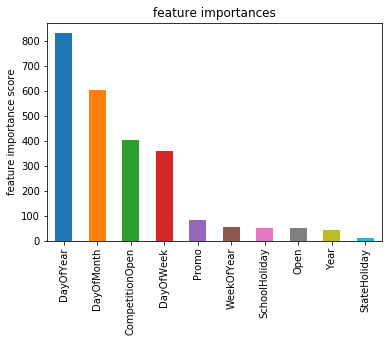

In [30]:
# xgb4 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
#                         max_depth=8,min_child_weight=12,
#                         subsample=0.8,colsample_bytree=0.8,
#                         nthread=4,scale_pos_weight=1,seed=27
#                         )
modelfit(xgb3,rossm_train[8],rossm_test[8],a1)

# 对全量数据通过xgboost测试调优

In [ ]:
xgb8 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=8000,gamma=0,reg_alpha=1e-05,
                        max_depth=8,min_child_weight=14,
                        colsample_bytree=0.8,subsample=1,scale_pos_weight=1,seed=27
                        )
xgb8.fit(train[a1],train[goal])
train_predict = xgb8.predict(train[a1])
#     train_predprob = xgb1.predict_proba(train[features])[:,1]


In [ ]:
    
print('\n Model Report')
print('error: %.4g' % rmspe(train[goal].values,train_predict))
    
feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar',title="feature importances")
plt.ylabel('feature importance score')
# modelfit(xgb8,train,test,a1)